In [88]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
import rioxarray as rxr
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.enums import Resampling
import geopandas as gpd
import xarray as xr
import pandas as pd
import glob
import os
import seaborn as sns
from scipy.stats import linregress

In [82]:
#Output Folders
folder = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/'
BSL = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/23_BSL/big_spirit_lake.shp'
output = folder + 'GP_GP_Final/'
S3_path = output + 'Sentinel-3_BSL_RPJ.tif'
S3_idw = output + 'S3_idw.tif'

In [8]:
test = rxr.open_rasterio(S3_path, masked = True)
new_crs = 'EPSG:32615'
name = 'Sentinel-3_BSL_RPJ.tif'
rpj_ra = test.rio.reproject(new_crs)
rpj_ra.rio.to_raster(output + name)

/mnt/nfs/lss/meerdink/home/skzebarth/.conda/envs/geo/lib/python3.11/site-packages/rioxarray/raster_writer.py:132: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [83]:
def S3_NDCI(dir,
             shape,
             plot = False,
             save = False):
    
    shapei = gpd.read_file(shape)
    shape = shapei.to_crs(32615)
    PS_raster = rxr.open_rasterio(dir, masked = True)
    red = PS_raster.sel(band=8)
    red_edge = PS_raster.sel(band=11)
    
    clipped_red = red.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
    clipped_red_edge = red_edge.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False) 
    
    
    NDCI = (clipped_red_edge - clipped_red) / (clipped_red_edge + clipped_red) 
    
    if plot == True:
        NDCI.plot(
            cmap = 'gnuplot', vmax =1, vmin = -1)
        plt.title(f"Sentinel-3 Big Spirit Lake NDCI")
   
    if save == True:
        outname = f"Sentinel-3_BSL_NDCI_RPJ.tif"
        NDCI.rio.to_raster(os.path.join(output, outname), driver='GTIFF')
    
    return NDCI

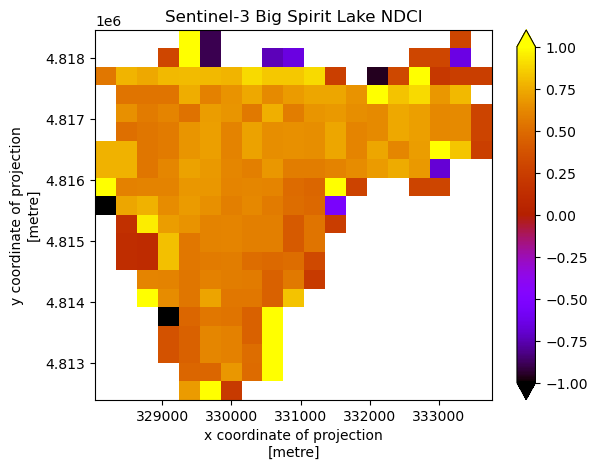

In [84]:
NDCI = S3_NDCI(S3_path,
              BSL,
              True,
              False)

In [85]:
NDCI_flat = NDCI.values.flatten()
NDCI_flat = NDCI_flat[~np.isnan(NDCI_flat)]
NDCI_filtered = NDCI_flat[(NDCI_flat >= -1) & (NDCI_flat <= 1)]

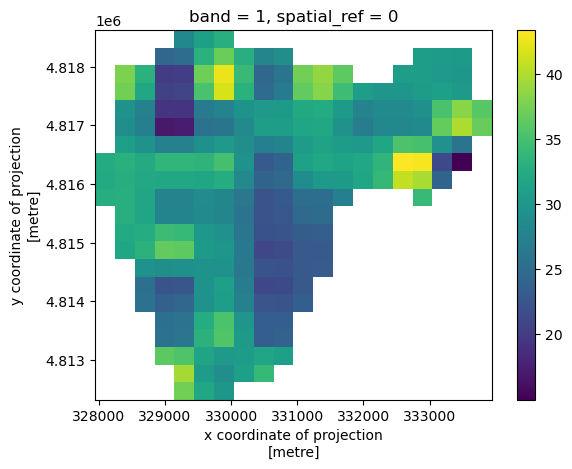

In [57]:
idw = rxr.open_rasterio(S3_idw)
shapei = gpd.read_file(BSL)
shape = shapei.to_crs(32615)
clipped_idw = idw.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
clipped_idw.squeeze().plot.imshow(interpolation='none')

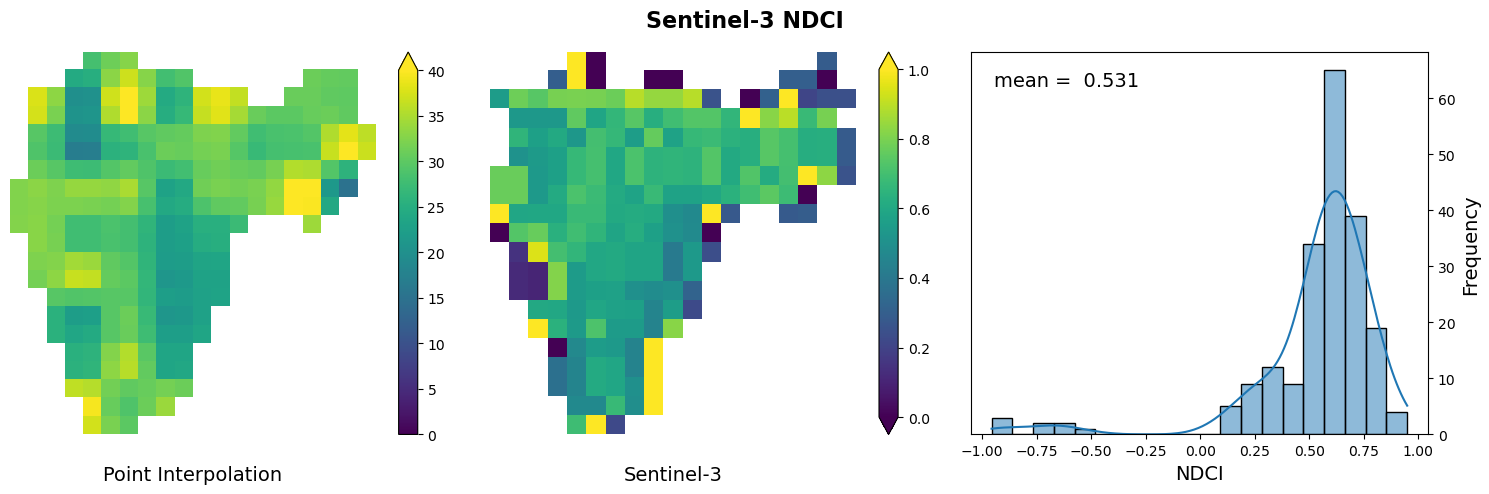

In [86]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))
mean = np.mean(NDCI_filtered)    
a = NDCI 
b = clipped_idw

b.squeeze().plot.imshow(cmap = 'viridis', 
                        vmax=40, 
                        vmin=0, 
                        ax=ax0)
ax0.axis('off')
ax0.set_title("Point Interpolation", y=0, pad=-22, verticalalignment="top", fontsize=14)

a.squeeze().plot.imshow(cmap = 'viridis', 
              vmax =1, 
              vmin = 0, 
              ax=ax1)
ax1.axis('off')
ax1.set_title("Sentinel-3", y=0, pad=-22, verticalalignment="top", fontsize=14)
sns.histplot(NDCI_filtered, 
             bins=20,
                 kde=True, 
                 ax=ax2)
ax2.set_xlabel('NDCI', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.text(.05, .95, f'mean = {mean: .3f}', transform=ax2.transAxes, verticalalignment='top', fontsize=14)
   
    
fig.suptitle(f'Sentinel-3 NDCI', fontsize=16, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(output, f'Sentinel-3_NDCI_fig'), dpi=1200, bbox_inches='tight')
plt.show()